In [1]:
# Configure plotting in Jupyter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (7.5, 7.5),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})
# Seed random number generator
import random
from numpy import random as nprand
seed = hash("Network Science in Python") % 2**32
nprand.seed(seed)
random.seed(seed)
# Import NetworkX
import networkx as nx

## Strong and Weak Ties

In [2]:
G = nx.karate_club_graph()
# Annotate with splinter club label
member_club = [
    0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
    0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
    1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1, 1, 1]
nx.set_node_attributes(G, dict(enumerate(member_club)), 'club')
# Find internal and external edges
internal = [(v, w) for v, w in G.edges if G.nodes[v]['club'] == G.nodes[w]['club']]
external = [(v, w) for v, w in G.edges if G.nodes[v]['club'] != G.nodes[w]['club']]
# Update edge attributes
nx.set_edge_attributes(G, dict((e, 'internal') for e in internal), 'internal')
nx.set_edge_attributes(G, dict((e, 'external') for e in external), 'internal')

In [3]:
def tie_strength(G, v, w):
    # Get neighbors of nodes v and w in G
    v_neighbors = set(G.neighbors(v))
    w_neighbors = set(G.neighbors(w))
    # Return size of the set intersection
    return 1 + len(v_neighbors & w_neighbors)

strength = dict(
    ((v,w), tie_strength(G, v, w))
    for v, w in G.edges())

In [4]:
def bridge_span(G):
    # Get list of edges
    edges = G.edges()
    # Copy G
    G = nx.Graph(G)
    # Create result dict
    result = dict()
    for v, w in edges:
        # Temporarily remove edge
        G.remove_edge(v, w)
        # Find distance with edge removed
        try:
            d = nx.shortest_path_length(G, v, w)
            result[(v, w)] = d
        except nx.NetworkXNoPath:
            result[(v, w)] = float('inf')
        # Restore edge
        G.add_edge(v, w)
    return result

span = bridge_span(G)

In [5]:
# Order edges by tie strength
ordered_edges = sorted(strength.items(), key=lambda x: x[1])
print('Edge\t  Strength\tSpan\tInternal')
# Print 10 strongest
for e, edge_strength in ordered_edges[:10]:
    print('{:10}{}\t\t{}\t{}'.format(
        str(e), edge_strength, span[e], G.edges[e]['internal']
    ))
print('...')
# Print 10 weakest
for e, edge_strength in ordered_edges[-10:]:
    print('{:10}{}\t\t{}\t{}'.format(
        str(e), edge_strength, span[e], G.edges[e]['internal']
    ))

Edge	  Strength	Span	Internal
(0, 11)   1		inf	internal
(0, 31)   1		3	external
(1, 30)   1		3	external
(2, 9)    1		3	external
(2, 27)   1		3	external
(2, 28)   1		3	external
(9, 33)   1		3	internal
(13, 33)  1		3	external
(19, 33)  1		3	external
(23, 25)  1		3	internal
...
(8, 32)   4		2	internal
(23, 33)  4		2	internal
(29, 33)  4		2	internal
(1, 2)    5		2	internal
(1, 3)    5		2	internal
(2, 3)    5		2	internal
(0, 2)    6		2	internal
(0, 3)    6		2	internal
(0, 1)    8		2	internal
(32, 33)  11		2	internal


## The Small World Problem

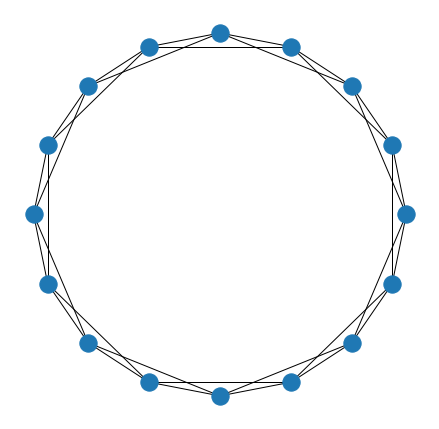

In [6]:
G_small_ring = nx.watts_strogatz_graph(16, 4, 0)
pos = nx.circular_layout(G_small_ring)
nx.draw_networkx(G_small_ring, pos=pos, with_labels=False)

In [7]:
G_ring = nx.watts_strogatz_graph(4000, 10, 0)

In [8]:
nx.average_shortest_path_length(G_ring)

200.45011252813202

In [9]:
nx.average_clustering(G_ring)

0.6666666666666546

### A Real Social Network

In [10]:
# Load data file into network
from pathlib import Path
data_dir = Path('.') / 'data'
G_social = nx.read_edgelist(data_dir / 'mcauley2012' / 'facebook_combined.txt')

In [11]:
nx.average_shortest_path_length(G_social)

3.6925068496963913

In [12]:
nx.average_clustering(G_social)

0.6055467186200876

# Random Network

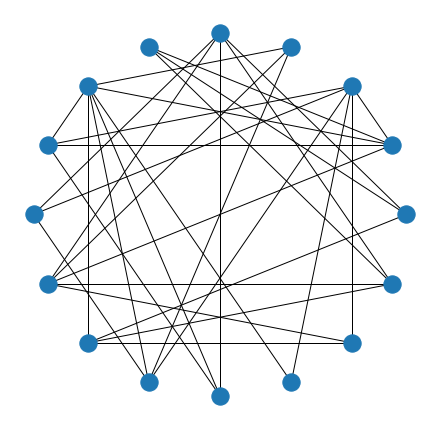

In [13]:
G_small_random = nx.watts_strogatz_graph(16, 4, 1)
pos = nx.circular_layout(G_small_random)
nx.draw_networkx(G_small_random, pos=pos, with_labels=False)

In [14]:
G_random = nx.watts_strogatz_graph(4000, 10, 1)

In [15]:
nx.average_shortest_path_length(G_random)

3.8667969492373095

In [16]:
nx.average_clustering(G_random)

0.0022751913527648826

### Watts-Strogatz Model

In [17]:
path = []
clustering = []
# Try a range of rewiring probabilities
p = [10**(x) for x in range(-6, 1)]
for p_i in p:
    path_i = []
    clustering_i =[]
    # Create 10 models for each probability
    for n in range(10):
        G = nx.watts_strogatz_graph(1000, 10, p_i)
        path_i.append(nx.average_shortest_path_length(G))
        clustering_i.append(nx.average_clustering(G))
    # Average the properties for each p_i
    path.append(sum(path_i) / len(path_i))
    clustering.append(sum(clustering_i) / len(clustering_i))

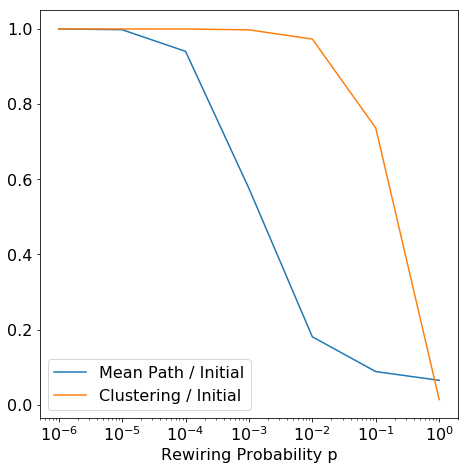

In [18]:
# Plot the results
fig, ax = plt.subplots()
for spine in ax.spines.values():
    spine.set_visible(True)
plt.semilogx(p, [x / path[0] for x in path], label='Mean Path / Initial')
plt.semilogx(p, [x / clustering[0] for x in clustering], label='Clustering / Initial')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('Rewiring Probability p', fontsize=16)
plt.legend(fontsize=16)

## Contagion
### Simple Contagion

In [19]:
def propagate_simple(G):
    to_infect = set([])
    # Find infected nodes
    for v in G.nodes():
        if G.nodes[v]['infected'] == False:
            # Mark all neighbors for infection
            for w in nx.neighbors(G, v):
                if G.nodes[w]['infected']:
                    to_infect.add(v)
                    break
    # Infect marked nodes
    for v in to_infect:
        G.nodes[v]['infected'] = True

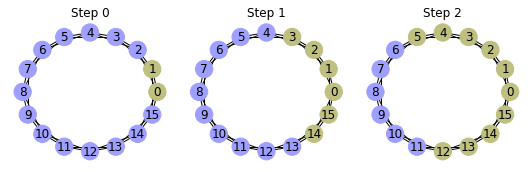

In [20]:
# Infect two nodes
nx.set_node_attributes(
    G_small_ring,
    dict((i, False) for i in range(16)),
    'infected')
for i in range(2):
    G_small_ring.nodes[i]['infected'] = True

# Visualize first three time steps
plt.figure(figsize=(7.5, 2.5))
for i in range(3):
    # Visualize
    plt.subplot(1, 3, i + 1)
    node_color = [
        '#bfbf7f' if G_small_ring.nodes[v]['infected'] else '#9f9fff'
        for v in G_small_ring.nodes]
    nx.draw_networkx(
        G_small_ring,
        pos=nx.circular_layout(G_small_ring),
        node_color=node_color)
    # Propagate the contagion
    propagate_simple(G_small_ring)
    plt.title("Step {}".format(i))
plt.tight_layout()

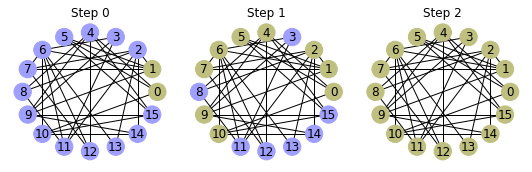

In [21]:
# Infect two nodes
nx.set_node_attributes(
    G_small_random,
    dict((i, False) for i in range(16)),
    'infected')
for i in range(2):
    G_small_random.nodes[i]['infected'] = True

# Visualize first three time steps
plt.figure(figsize=(7.5, 2.5))
for i in range(3):
    # Visualize
    plt.subplot(1, 3, i + 1)
    node_color = [
        '#bfbf7f' if G_small_random.nodes[v]['infected'] else '#9f9fff'
        for v in G_small_random.nodes]
    nx.draw_networkx(
        G_small_random,
        pos=nx.circular_layout(G_small_random),
        node_color=node_color)
    # Propagate the contagion
    propagate_simple(G_small_random)
    plt.title("Step {}".format(i))
plt.tight_layout()

### Complex Contagion

In [22]:
def propagate_complex(G):
    to_infect = set([])
    # Find uninfected nodes
    for v in G.nodes():
        if G.nodes[v]['infected'] == False:
            infected_neighbors = 0
            # Count infected neighbors
            for w in nx.neighbors(G, v):
                if G.nodes[w]['infected']:
                    infected_neighbors += 1
            # Remember nodes with 2+ infected neighbors
            if infected_neighbors >= 2:
                to_infect.add(v)
    # Infect new nodes
    for v in to_infect:
        G.nodes[v]['infected'] = True

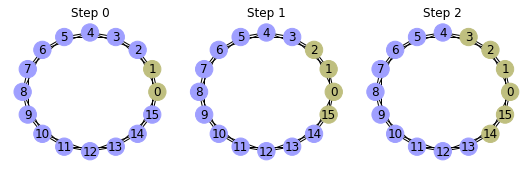

In [23]:
# Infect two nodes
nx.set_node_attributes(
    G_small_ring,
    dict((i, False) for i in range(16)),
    'infected')
for i in range(2):
    G_small_ring.nodes[i]['infected'] = True

# Visualize first three time steps
plt.figure(figsize=(7.5, 2.5))
for i in range(3):
    # Visualize
    plt.subplot(1, 3, i + 1)
    node_color = [
        '#bfbf7f' if G_small_ring.nodes[v]['infected'] else '#9f9fff'
        for v in G_small_ring.nodes]
    nx.draw_networkx(
        G_small_ring,
        pos=nx.circular_layout(G_small_ring),
        node_color=node_color)
    # Propagate the contagion
    propagate_complex(G_small_ring)
    plt.title("Step {}".format(i))
plt.tight_layout()

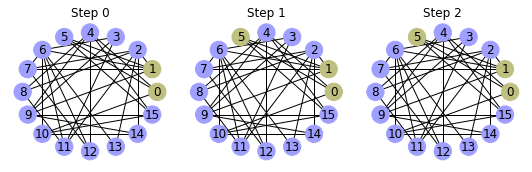

In [24]:
# Infect two nodes
nx.set_node_attributes(
    G_small_random,
    dict((i, False) for i in range(16)),
    'infected')
for i in range(2):
    G_small_random.nodes[i]['infected'] = True

# Visualize first three time steps
plt.figure(figsize=(7.5, 2.5))
for i in range(3):
    # Visualize
    plt.subplot(1, 3, i + 1)
    node_color = [
        '#bfbf7f' if G_small_random.nodes[v]['infected'] else '#9f9fff'
        for v in G_small_random.nodes]
    nx.draw_networkx(
        G_small_random,
        pos=nx.circular_layout(G_small_random),
        node_color=node_color)
    # Propagate the contagion
    propagate_complex(G_small_random)
    plt.title("Step {}".format(i))
plt.tight_layout()